In [225]:
import numpy as np
import pymc3 as pm
from theano import shared
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns

In [21]:
d = pd.read_csv("https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/rugged.csv", sep = ";")

d["log_gdp"] = np.log(d.rgdppc_2000)
d = d.dropna(axis = 0, subset = ["log_gdp"])

d["log_gdp_std"] = d["log_gdp"] / np.mean(d["log_gdp"])
d["rugged_std"] = d["rugged"]/np.max(d["rugged"]) 

[]

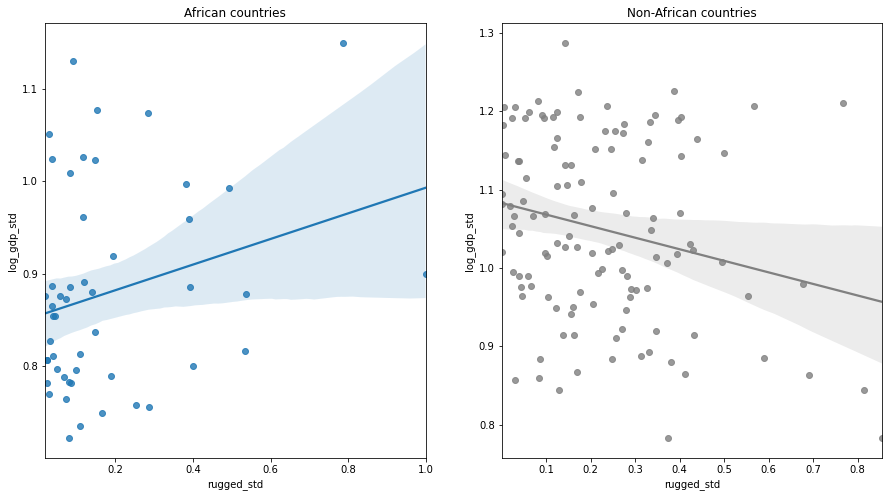

In [235]:
fig, ax = plt.subplots(1,2, figsize = (15,8))

sns.regplot(d.loc[d.cont_africa==1, "rugged_std"], d.loc[d.cont_africa==1, "log_gdp_std"], ax=ax[0])
sns.regplot(d.loc[d.cont_africa==0, "rugged_std"], d.loc[d.cont_africa==0, "log_gdp_std"], ax=ax[1], color = "grey")

ax[0].set_title("African countries")
ax[1].set_title("Non-African countries")

plt.plot()

$log(y_i) \sim Normal(\mu_i,\sigma)$

$\mu_i = \alpha + \beta_i(r_i - \hat{r})$ 

$\alpha \sim Normal(1, 1)$

$\beta \sim Normal(0, 1)$

In [204]:
m8_1 = pm.Model()
R = shared(d.rugged_std.values)
R_hat = np.mean(d.rugged_std)

with m8_1:
    sigma = pm.Exponential("sigma", 1)
    alpha = pm.Normal("alpha", 1, 1)
    bR = pm.Normal("bR", 0, 1)
    mu = pm.Deterministic("mu", alpha + bR * (R - R_hat))
    G = pm.Normal("G", mu, sigma, observed = d.log_gdp_std.values)
    m8_1_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bR, alpha, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [51]:
with m8_1:
    m8_1_prior = pm.sample_prior_predictive()

x_seq = np.linspace(0,1,num=m8_1_a.shape[0])

m8_1_a = m8_1_prior["alpha"]
m8_1_b = m8_1_prior["bR"]

In [71]:
np.sum(np.abs(m8_1_b) > 0.6) / m8_1_b.shape[0]

0.538

$\alpha \sim Normal(1, 0.1)$

$\beta \sim Normal(0, 0.3)$

In [125]:
with pm.Model() as m8_1b:
    sigma = pm.Exponential("sigma", 1)
    alpha = pm.Normal("alpha", 1, 0.1)
    bR = pm.Normal("bR", 0, 0.3)
    mu = pm.Deterministic("mu", alpha + bR * (R - R_hat))
    G = pm.Normal("G", mu, sigma, observed = d.log_gdp_std.values)
    m8_1b_trace = pm.sample()

with m8_1b:
    m8_1b_prior = pm.sample_prior_predictive()

m8_1b_a = m8_1b_prior["alpha"]
m8_1b_b = m8_1b_prior["bR"]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bR, alpha, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


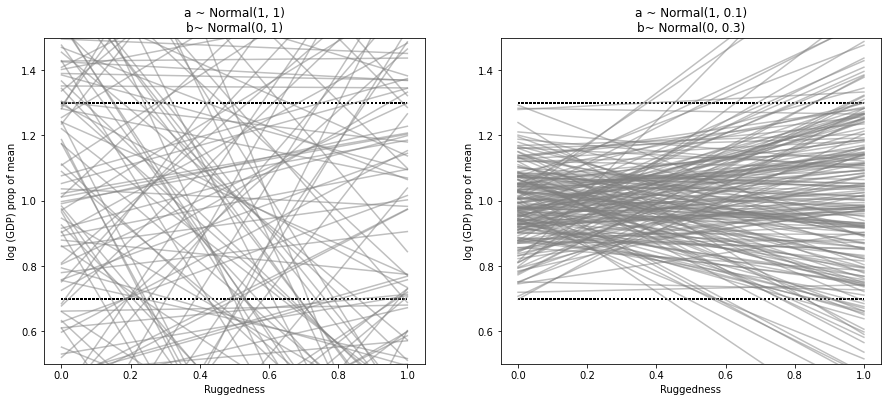

In [126]:
fig, ax = plt.subplots(1,2, figsize = (15,6))

for i in range(200):
    ax[0].plot(x_seq, m8_1_a[i] + m8_1_b[i] * (x_seq - R_hat), color = "grey", alpha = 0.5)
    ax[0].set_ylim(0.5, 1.5)
    ax[0].hlines(1.3, xmin = 0, xmax = 1, linestyle = ":", color = "black")
    ax[0].hlines(0.7, xmin = 0, xmax = 1, linestyle = ":", color = "black")
    ax[0].set_title("a ~ Normal(1, 1)\nb~ Normal(0, 1)")
    ax[0].set_xlabel("Ruggedness")
    ax[0].set_ylabel("log (GDP) prop of mean")
for i in range(200):
    ax[1].plot(x_seq, m8_1b_a[i] + m8_1b_b[i] * (x_seq - R_hat), color = "grey", alpha = 0.5)
    ax[1].set_ylim(0.5, 1.5)
    ax[1].hlines(1.3, xmin = 0, xmax = 1, linestyle = ":", color = "black")
    ax[1].hlines(0.7, xmin = 0, xmax = 1, linestyle = ":", color = "black")
    ax[1].set_title("a ~ Normal(1, 0.1)\nb~ Normal(0, 0.3)")
    ax[1].set_xlabel("Ruggedness")
    ax[1].set_ylabel("log (GDP) prop of mean")

In [127]:
az.summary(m8_1b_trace, kind = "stats", round_to=2, var_names = ["alpha", "bR", "sigma"])

,mean,sd,hdi_3%,hdi_97%
alpha,1.00,0.01,0.98,1.02
bR,0.00,0.06,-0.10,0.11
sigma,0.14,0.01,0.12,0.15


In [205]:
# set categorical variable
cid = pd.Categorical(d.cont_africa)

with pm.Model() as m8_2:
    sigma = pm.Exponential("sigma", 1)
    alpha = pm.Normal("alpha", 1, 0.1, shape = 2)
    bR = pm.Normal("bR", 0, 0.3)
    mu = pm.Deterministic("mu", alpha[cid] + bR * (R - R_hat))
    G = pm.Normal("G", mu, sigma, observed = d.log_gdp_std.values)
    m8_2_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bR, alpha, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [206]:
az.compare({"m8_1_b": m8_1b_trace, "m8_2": m8_2_trace}, ic = "waic", scale = "deviance")

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m8_2,0,-251.983,4.28007,0,0.999971,13.0537,0,True,deviance
m8_1_b,1,-180.605,6.40857,71.3774,2.91145e-05,14.7825,14.8832,False,deviance


In [207]:
az.summary(m8_2_trace, kind = "stats", var_names = ["alpha", "bR", "sigma"])

,mean,sd,hdi_3%,hdi_97%
alpha[0],1.049,0.011,1.031,1.070
alpha[1],0.881,0.016,0.852,0.913
bR,-0.046,0.047,-0.129,0.048
sigma,0.114,0.007,0.103,0.126


In [145]:
d_a = m8_2_trace["alpha"][:,1] - m8_2_trace["alpha"][:,0]
az.summary(d_a, kind = "stats", hdi_prob = 0.97)

,mean,sd,hdi_1.5%,hdi_98.5%
x,-0.169,0.02,-0.214,-0.129


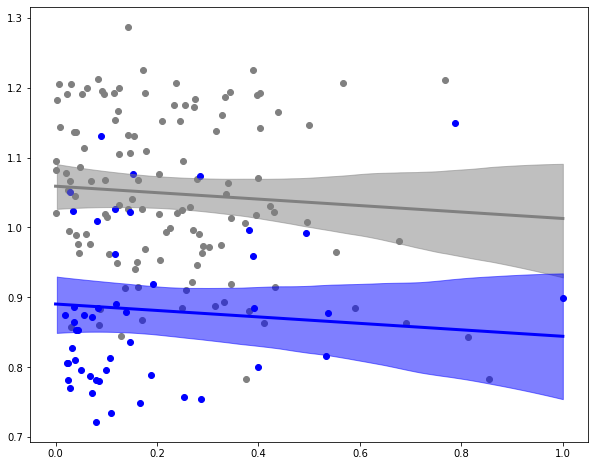

In [223]:
x_seq = np.linspace(0, 1, num=m8_2_trace["bR"].shape[0])

fig, ax = plt.subplots(figsize = (10,8))

ax.scatter(d.rugged_std[cid ==0], d.log_gdp_std[cid ==0], color = "grey")
ax.scatter(d.rugged_std[cid ==1], d.log_gdp_std[cid ==1], color = "blue")

pred0 = m8_2_trace["alpha"][:,0] + m8_2_trace["bR"] * (x_seq - R_hat).reshape(-1,1)
pred1 = m8_2_trace["alpha"][:,1] + m8_2_trace["bR"] * (x_seq - R_hat).reshape(-1,1)

ax.plot(x_seq, m8_2_trace["alpha"][:,0].mean() + m8_2_trace["bR"].mean() * (x_seq - R_hat), color = "grey", linewidth = 3)
az.plot_hdi(x_seq, pred0.T, hdi_prob=0.97, color="grey", ax = ax)
ax.plot(x_seq, m8_2_trace["alpha"][:,1].mean() + m8_2_trace["bR"].mean() * (x_seq - R_hat), linewidth = 3, color = "blue")
az.plot_hdi(x_seq, pred1.T, hdi_prob=0.97, color="blue", ax = ax)
plt.show()

In [239]:
with pm.Model() as m8_3:
    sigma = pm.Exponential("sigma", 1)
    alpha = pm.Normal("alpha", 1, 0.1, shape = 2)
    bR = pm.Normal("bR", 0, 0.3, shape = 2)
    mu = pm.Deterministic("mu", alpha[cid] + bR[cid] * (R - R_hat))
    G = pm.Normal("G", mu, sigma, observed = d.log_gdp_std.values)
    m8_3_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bR, alpha, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [241]:
az.summary(m8_3_trace, var_names=["alpha", "bR", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],1.051,0.010,1.032,1.069,0.000,0.000,8838.0,8838.0,8836.0,3386.0,1.00
alpha[1],0.886,0.016,0.857,0.917,0.000,0.000,6342.0,6342.0,6330.0,3192.0,1.00
bR[0],-0.143,0.056,-0.242,-0.034,0.001,0.001,5733.0,4987.0,5726.0,3171.0,1.00
bR[1],0.132,0.076,-0.010,0.269,0.001,0.001,6646.0,5123.0,6663.0,3189.0,1.00
sigma,0.111,0.006,0.100,0.123,0.000,0.000,5873.0,5845.0,5864.0,2696.0,1.01


In [242]:
az.compare({"m8_1_b": m8_1b_trace, "m8_2": m8_2_trace, "m8_3": m8_3_trace}, ic = "waic", scale = "deviance")

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m8_3,0,-259.23,4.99438,0,0.843434,13.2502,0,True,deviance
m8_2,1,-251.983,4.28007,7.24754,0.156566,14.0135,6.52188,True,deviance
m8_1_b,2,-180.605,6.40857,78.6249,4.70063e-11,13.8639,15.2689,False,deviance


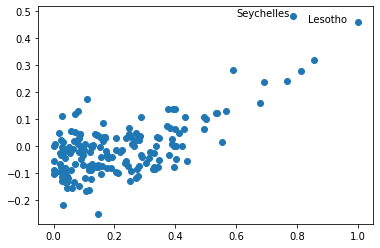

In [290]:
psis = az.loo(m8_3_trace, pointwise=True, scale="deviance")

plt.scatter(x = d.rugged_std, y = psis.pareto_k)
for i in range(0, d.shape[0]):
    if(psis.pareto_k[i] > 0.4):
        plt.text(x = d.rugged_std.values[i]-0.1, y = psis.pareto_k[i], s = d.country.values[i], ha = "center")

plt.show()

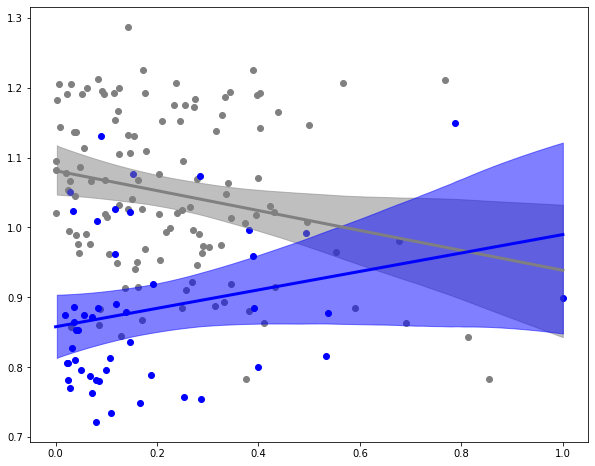

In [295]:
x_seq = np.linspace(0, 1, num=m8_3_trace["bR"].shape[0])

fig, ax = plt.subplots(figsize = (10,8))

ax.scatter(d.rugged_std[cid ==0], d.log_gdp_std[cid ==0], color = "grey")
ax.scatter(d.rugged_std[cid ==1], d.log_gdp_std[cid ==1], color = "blue")

pred0 = m8_3_trace["alpha"][:,0] + m8_3_trace["bR"][:,0] * (x_seq - R_hat).reshape(-1,1)
pred1 = m8_3_trace["alpha"][:,1] + m8_3_trace["bR"][:,1] * (x_seq - R_hat).reshape(-1,1)

ax.plot(x_seq, m8_3_trace["alpha"][:,0].mean() + m8_3_trace["bR"][:,0].mean() * (x_seq - R_hat), color = "grey", linewidth = 3)
az.plot_hdi(x_seq, pred0.T, hdi_prob=0.97, color="grey", ax = ax)
ax.plot(x_seq, m8_3_trace["alpha"][:,1].mean() + m8_3_trace["bR"][:,1].mean() * (x_seq - R_hat), linewidth = 3, color = "blue")
az.plot_hdi(x_seq, pred1.T, hdi_prob=0.97, color="blue", ax = ax)
plt.show()